# Classification using TF-IDF & spaCy

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings("ignore")
from sklearn_evaluation.plot import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


import string

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

pd.set_option('display.max_colwidth',100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nihar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nihar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nihar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read data frame
df = pd.read_csv('News Aggregator/uci-news-aggregator.csv')

# Description of the dataset
print('SHAPE OF DATASET: ', df.shape, '\n\nCOLUMNS IN DATASET: ', df.columns, '\n\nCATEGORIES: ', df.CATEGORY.unique(), '\n\nDATA SAMPLE: \n\n', df.sample(n=5), '\n\n')

SHAPE OF DATASET:  (422406, 8) 

COLUMNS IN DATASET:  Index(['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME',
       'TIMESTAMP'],
      dtype='object') 

CATEGORIES:  ['b' 't' 'e' 'm'] 

DATA SAMPLE: 

             ID  \
103434  103634   
256894  257349   
227826  228279   
202301  202743   
93993    94189   

                                                                   TITLE  \
103434  Andrew Garfield: I love being naked, it's nothing to be shy over   
256894        Ann Hornaday Responds To Seth Rogen's Tweet Over Shootings   
227826  Lana Del Rey to perform at Kim Kardashian, Kanye West's wedding?   
202301       Eurovision 2014: watch all the finalists' performances here   
93993               Amazon's Prime Instant Video triples video streaming   

                                                                                                        URL  \
103434  http://metro.co.uk/2014/04/11/andrew-garfield-i-love-being-naked-its-nothing-to-be-shy-over-

In [3]:
#Converting categories as balanced
num_of_categories = 45639 #45639
shuffled = df.reindex(np.random.permutation(df.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))

In [4]:
concated.CATEGORY.value_counts()

e    45639
m    45639
b    45639
t    45639
Name: CATEGORY, dtype: int64

In [5]:
concated.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
92576,309323,change opens door to rogues,http://www.stuff.co.nz/southland-times/technology/60116891/Google-Play-change-opens-door-to-rogues,The Southland Times,t,dBFKOQ-KOcMgY1MZNebRMCk6PzXSM,www.stuff.co.nz,1.403550e+12
55063,192533,US urges restraint in Vietnam-China rig standoff,http://www.ourwindsor.ca/news-story/4506944-us-urges-restraint-in-vietnam-china-rig-standoff/,OurWindsor.ca,b,dNon3QbHmjev9RMZBV7iFz3EK5TRM,www.ourwindsor.ca,1.399560e+12
100129,260319,Microsoft unveils 'real-time' translating function for Skype,http://www.thedrum.com/news/2014/05/28/microsoft-unveils-real-time-translating-function-skype,The Drum,t,dR4u0M6btXOAJNMYimHwI9aziWkFM,www.thedrum.com,1.401290e+12
75647,60783,"GBP/USD bounced back from 1.66, but may attack again",http://www.fxstreet.com/news/forex-news/article.aspx\?storyid=34ab05ec-612d-4313-94b2-1f28cb37bd...,FXstreet.com,b,dEIyCRbEMAXMiNMV7JhWBb05S7FsM,www.fxstreet.com,1.396070e+12
125629,25867,Blackberry Z3 vs Samsung Galaxy S5: Price & Specification Comparison,http://www.gamerheadlines.com/2014/03/blackberry-z3-vs-samsung-galaxy-s5-price-specification-com...,The Gamer Headlines,t,dYnGXrRyxeSSQyM475Lx4H5Xch0yM,www.gamerheadlines.com,1.395320e+12


In [6]:
# remove duplicates
concated = concated.drop_duplicates()
concated.isnull().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    0
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [7]:
#Addting 2 columns as feature

concated['text'] = concated.TITLE + " " + concated.PUBLISHER
concated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182556 entries, 92576 to 53028
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         182556 non-null  int64  
 1   TITLE      182556 non-null  object 
 2   URL        182556 non-null  object 
 3   PUBLISHER  182556 non-null  object 
 4   CATEGORY   182556 non-null  object 
 5   STORY      182556 non-null  object 
 6   HOSTNAME   182556 non-null  object 
 7   TIMESTAMP  182556 non-null  float64
 8   text       182556 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 13.9+ MB


In [8]:
# Drop null
concated= concated.dropna(subset=['text'])

In [9]:
concated.text.iloc[86]

'At The Movies 4.17.14 Fort Smith Times Record'

In [10]:
concated['text'].dropna(inplace=True)

In [11]:
concated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182556 entries, 92576 to 53028
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         182556 non-null  int64  
 1   TITLE      182556 non-null  object 
 2   URL        182556 non-null  object 
 3   PUBLISHER  182556 non-null  object 
 4   CATEGORY   182556 non-null  object 
 5   STORY      182556 non-null  object 
 6   HOSTNAME   182556 non-null  object 
 7   TIMESTAMP  182556 non-null  float64
 8   text       182556 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 13.9+ MB


In [12]:
concated.text.iloc[86]

'At The Movies 4.17.14 Fort Smith Times Record'

In [13]:
#concated['text'] = concated['text'].str.replace('[^\w\s]','') # unpunctuate

symbols = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', 
           ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', 
           '#', '*', '+', '\\', '•',  '~', '@', '£', '·', '_', 
           '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', 
           '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
           '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', 
           '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', 
           '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', 
           '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', 
           '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', 
           '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', 
           '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
           '¹', '≤', '‡', '√', ]

def clean_symbol(text):
    text = str(text)
    for symbol in symbols:
        text = text.replace(symbol, '')
    return text

# remove symbols and punctuations 
concated['text'] = concated['text'].apply(lambda x: clean_symbol(x))

In [14]:
import re
import string

def clean_text(text):
    text = re.sub("[0-9]+", "",text)
    text = text.lower() # lowercase text
    text = re.sub(' +',' ', text)
    tokens=re.split('\W+',text)
    text1 = " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation and len(word) > 2])
    return text1

concated['cleaned_text'] = concated['text'].apply(lambda x:clean_text(x))

In [15]:
concated['cleaned_text']

92576                                       change open door rogue southland time
55063                       urge restraint vietnamchina rig standoff ourwindsorca
100129                 microsoft unveils realtime translating function skype drum
75647                                  gbpusd bounced back may attack fxstreetcom
125629    blackberry samsung galaxy price specification comparison gamer headline
                                           ...                                   
12774                                                jacko died earlier newscomau
35517                              met mother concludes nineyear run futon critic
160616                        anxiety falsepositive mammogram temporary healthcom
105195            facebooks study got wrong seeing friend happy make sad guardian
53028                  dimon discloses throat cancer calling curable columbus ceo
Name: cleaned_text, Length: 182556, dtype: object

In [16]:
titles = concated['cleaned_text']
labels = concated['CATEGORY']

In [17]:
# Dictionary of short form words and mispellings
short_forms_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                    "'cause": "because", "could've": "could have", "couldn't": "could not", 
                    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                    "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                    "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                    "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                    "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                    "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                    "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                    "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                    "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", 
                    "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                    "you're": "you are", "you've": "you have"}

def clean_shortforms(text):
    clean_text = text
    for shortform in short_forms_dict.keys():
        if re.search(shortform, text):
            clean_text = re.sub(shortform, short_forms_dict[shortform], text)
    return clean_text

# fix short forms
titles = titles.apply(lambda x: clean_shortforms(x))

In [18]:
titles = titles.str.replace('[^\w\s]','')# unpunctuate

In [19]:
titles

92576                                       change open door rogue southland time
55063                       urge restraint vietnamchina rig standoff ourwindsorca
100129                 microsoft unveils realtime translating function skype drum
75647                                  gbpusd bounced back may attack fxstreetcom
125629    blackberry samsung galaxy price specification comparison gamer headline
                                           ...                                   
12774                                                jacko died earlier newscomau
35517                              met mother concludes nineyear run futon critic
160616                        anxiety falsepositive mammogram temporary healthcom
105195            facebooks study got wrong seeing friend happy make sad guardian
53028                  dimon discloses throat cancer calling curable columbus ceo
Name: cleaned_text, Length: 182556, dtype: object

In [20]:
labels

92576     t
55063     b
100129    t
75647     b
125629    t
         ..
12774     e
35517     e
160616    m
105195    t
53028     b
Name: CATEGORY, Length: 182556, dtype: object

In [21]:
def track_vocab(sentences, verbose =  True):
    
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
                
    return vocab

In [22]:
# tokenize all titles in the data
titles_token = titles.apply(lambda x: x.split())

In [23]:
# count the occurrence of all words in the data
vocab_count = track_vocab(titles_token)
print({k: vocab_count[k] for k in list(vocab_count)[:2]})

{'change': 1634, 'open': 1060}


Classification using TFIDF vectorizer

In [24]:
# Vectorize training and testing data
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    print('Vectorization complete.\n')
    
    return X_train_vec, X_test_vec

In [25]:
from sklearn.model_selection import cross_val_score
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        y_pred1= gs.predict(X_train)
     
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        a=accuracy_score(y_pred, y_test)*100
        print("Test Accuracy:",a)
        b=accuracy_score(y_pred1, y_train)*100
        print("Train Accuracy:",b)
        results_gs_cv = cross_val_score(gs, X_train, y_train, cv=10)
        print('Cross Validation Accuracy',results_gs_cv.mean()*100)
    
        # Print scores for the classifier
        print(confusion_matrix(y_test, y_pred, target_names = ['b','e','m','t']).grid(False))

    return

models = {
    'Naive Bayes': MultinomialNB()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False]}                
}



Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': True}
Test Accuracy: 93.51982032976062
Train Accuracy: 97.91609606460649
Cross Validation Accuracy 93.11678092203796
None


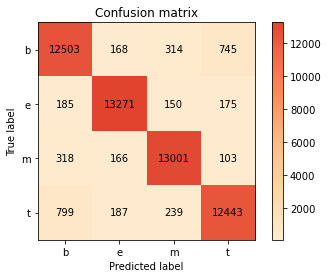

In [26]:
# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(titles, labels, test_size=0.3, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(ngram_range=(1,2)),X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

In [27]:
#X_features = pd.DataFrame(X_train_vec.toarray())
#X_features.head()

Log Regression

In [28]:
%%time
# First create the base model to tune
logreg = LogisticRegression(n_jobs=-1,random_state=8,solver='newton-cg',penalty='l2',multi_class='multinomial',class_weight= None)

# Fit the random search model
logreg.fit(X_train_vec,y_train)

Wall time: 1min 19s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=8, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
y_pred_log_test = logreg.predict(X_test_vec)
y_pred_log_train = logreg.predict(X_train_vec)
#results_log_cv = cross_val_score(logreg, X_train, y_train, cv=5)

# Model Accuracy
print("Logistic Test Accuracy:", accuracy_score(y_test, y_pred_log_test)*100)
print("Logistic Train Accuracy:", accuracy_score(y_train, y_pred_log_train)*100)
#print('Cross Validation Accuracy',results_log_cv.mean()*100)

Logistic Test Accuracy: 93.44678364708675
Logistic Train Accuracy: 97.37457840659212


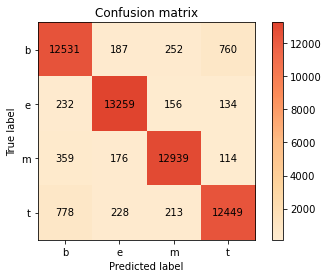

In [30]:
# Test Confusion Matrix
confusion_matrix(y_test, y_pred_log_test, target_names = ['b','e','m','t']).grid(False)

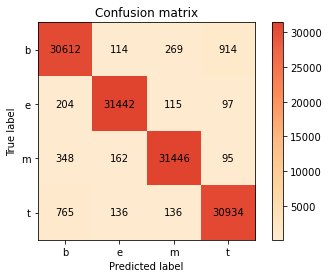

In [31]:
# Train Confusion Matrix
confusion_matrix(y_train, y_pred_log_train, target_names = ['b','e','m','t']).grid(False)

In [32]:
print(classification_report(y_test, y_pred_log_test))

              precision    recall  f1-score   support

           b       0.90      0.91      0.91     13730
           e       0.96      0.96      0.96     13781
           m       0.95      0.95      0.95     13588
           t       0.93      0.91      0.92     13668

    accuracy                           0.93     54767
   macro avg       0.93      0.93      0.93     54767
weighted avg       0.93      0.93      0.93     54767



SGD Classifier

In [33]:
%%time
sgd = SGDClassifier(n_jobs=-1, max_iter=15, shuffle=True,alpha=0.00001,verbose=True)
sgd.fit(X_train_vec,y_train)

y_pred_test_sgd = sgd.predict(X_test_vec)
y_pred_train_sgd = sgd.predict(X_train_vec)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


-- Epoch 1
Norm: 132.75, NNZs: 125082, Bias: -0.862178, T: 127789, Avg. loss: 0.106297
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 139.12, NNZs: 146230, Bias: -0.822296, T: 127789, Avg. loss: 0.152204
Total training time: 0.25 seconds.
-- Epoch 2
Norm: 132.85, NNZs: 123251, Bias: -0.636358, T: 127789, Avg. loss: 0.093188
Total training time: 0.16 seconds.
Norm: 145.36, NNZs: 159841, Bias: -0.731361, T: 127789, Avg. loss: 0.174583
Total training time: 0.29 seconds.
-- Epoch 2
-- Epoch 2
Norm: 117.07, NNZs: 166390, Bias: -0.741208, T: 255578, Avg. loss: 0.052107
Total training time: 0.34 seconds.
-- Epoch 3
Norm: 123.67, NNZs: 192313, Bias: -0.763805, T: 255578, Avg. loss: 0.081467
Total training time: 0.38 seconds.
-- Epoch 3
Norm: 115.89, NNZs: 164348, Bias: -0.582560, T: 255578, Avg. loss: 0.044408
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 129.76, NNZs: 205053, Bias: -0.691368, T: 255578, Avg. loss: 0.092664
Total training time: 0.41 

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.3s finished


Wall time: 3.02 s


In [34]:
f=accuracy_score(y_pred_test_sgd,y_test)*100
print ('Test Accuracy',f)

g=accuracy_score(y_pred_train_sgd,y_train)*100
print ('Train Accuracy',g)

Test Accuracy 94.94768747603484
Train Accuracy 98.62038203601249


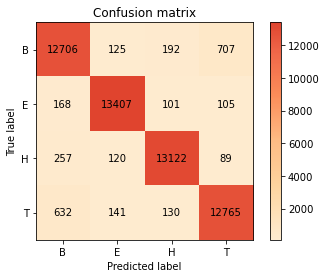

In [35]:
#Test confusion matrix
confusion_matrix(y_test, y_pred_test_sgd, target_names = ['B','E','H','T']).grid(False)

In [36]:
print(classification_report(y_test, y_pred_test_sgd))

              precision    recall  f1-score   support

           b       0.92      0.93      0.92     13730
           e       0.97      0.97      0.97     13781
           m       0.97      0.97      0.97     13588
           t       0.93      0.93      0.93     13668

    accuracy                           0.95     54767
   macro avg       0.95      0.95      0.95     54767
weighted avg       0.95      0.95      0.95     54767



In [37]:
# Evaluation matrix
bac=balanced_accuracy_score(y_test, y_pred_test_sgd)*100
c_k_s=cohen_kappa_score(y_test, y_pred_test_sgd)*100
mc=matthews_corrcoef(y_test, y_pred_test_sgd)*100

In [38]:
print(c_k_s)
print(mc)
print(bac)

93.26350065487014
93.26356462665912
94.94795713287458


In [39]:
#b= y_test + " " + y_pred_test_sgd + " "

In [40]:
#b.to_csv('labeltf.csv')

In [41]:
#X_test

In [42]:
#X_test.to_csv('texttf.csv')